In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from exp.nb_XLibrary import *

In [3]:
from fastai import datasets as FAdataset

# Path and data

In [4]:
home_path = Path('.').resolve()
data_path = home_path/'data'
file_path = FAdataset.untar_data(FAdataset.URLs.IMAGENETTE_160, dest=data_path)

In [5]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]
bs=128

il = ImageList.from_files(file_path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=1)
data.train_ds


LabeledData
x: ImageList (12894 items)
[PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_58454.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_32588.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_32422.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_33663.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_27948.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_38644.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_35076.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_38214.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_23008.JPEG'), PosixPath('/Users/xianli

Model

In [6]:
def normalize_chan(x, mean, std):
    return (x-mean[...,None,None]) / std[...,None,None]

_m = tensor([0.47, 0.48, 0.45])
_s = tensor([0.29, 0.28, 0.30])
norm_imagenette = partial(normalize_chan, mean=_m, std=_s)

In [7]:
nfs = [32,64,128,256]
# removed cuda callback from here
cbfs = [partial(AvgStatsCallback,accuracy),
        partial(BatchTransformXCallback, norm_imagenette)]

In [8]:
#image specific
import math
def prev_pow_2(x): return 2**math.floor(math.log2(x))
def get_cnn_layers(data, nfs, layer, **kwargs):
    def f(ni, nf, stride=2): return layer(ni, nf, 3, stride=stride, **kwargs)
    l1 = data.c_in
    l2 = prev_pow_2(l1*3*3)
    layers =  [f(l1  , l2  , stride=1),
               f(l2  , l2*2, stride=2),
               f(l2*2, l2*4, stride=2)]
    nfs = [l2*4] + nfs
    layers += [f(nfs[i], nfs[i+1]) for i in range(len(nfs)-1)]
    layers += [nn.AdaptiveAvgPool2d(1), Lambda(flatten),
               nn.Linear(nfs[-1], data.c_out)]
    return layers
def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [25]:
# vanilla SGD baseline performance
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)
run.fit(1, learn)

train: [1.7266094574026678, tensor(0.4010)]
valid: [1.388707275390625, tensor(0.5420)]


# A better optimizer

In [9]:
class Optimizer():
    def __init__(self,params, steppers, **defaults):
        self.param_groups = list(params)
        # ensure param_groups is a list of list
        if not isinstance(self.param_groups[0], list):
            self.param_groups = [self.param_groups]
        # init hyper-parameter dictionaries by defaults for each parameter group
        self.hypers = [{**defaults} for _ in self.param_groups]
        self.steppers = listify(steppers)
    
    def grad_params(self): # get all the parameters that have a gradient
        return [(p,hyper) for pg,hyper in zip(self.param_groups,self.hypers)
            for p in pg if p.grad is not None]
    
    def zero_grad(self):
        for p, hyper in self.grad_params():
            p.grad.detach_()
            p.grad.zero_()
    
    def step(self):
        for p, hyper in self.grad_params():
            compose(p, self.steppers, **hyper) # these **hyper will be passed as parameters for stepper

basic SGD stepper

In [10]:
#export
def sgd_step(p, lr, **kwargs):
    p.data.add_(-lr, p.grad.data) # this is p -= lr*p.grad
    return p

In [11]:
opt_func = partial(Optimizer, steppers=[sgd_step])

In [12]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 

In [13]:
cbfs = [partial(AvgStatsCallback,accuracy),
        Recorder,
        partial(ParamScheduler, 'lr', sched)]

In [15]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs, opt_func=opt_func)

In [35]:
%time run.fit(1, learn)

train: [1.7781989806305258, tensor(0.3843)]
valid: [1.441894287109375, tensor(0.5180)]
CPU times: user 4min 24s, sys: 1min 20s, total: 5min 45s
Wall time: 2min 56s


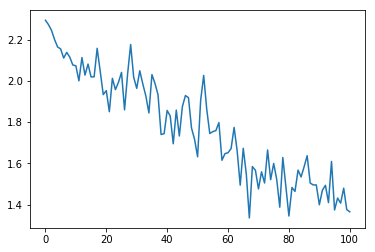

In [40]:
run.recorder.plot_loss()

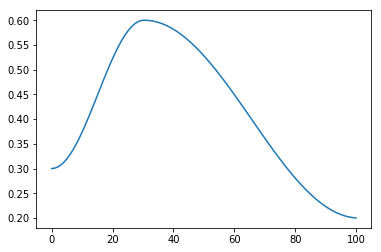

In [41]:
run.recorder.plot_lr()

# Weight decay

weight decay vs. L2 regularization:
1. In basic SGD, they are the same thing. But implementation-wise they are different:

 - L2 regualrizatoin 
``` python
loss_with_wd = loss + (wd/2) * (weights**2).sum()
```
 - weight decay
``` python
weight.grad += wd * weight
weight = weight - lr*(weight.grad + wd*weight)
```
 It's called "weight decay", as each weight is decayed by a factor `lr * wd`
 
 
2. In momentum, RMSProp and Adam, additional terms around gradient are there, so the update is different between L2 regularization and weight decay
 - Weight decay is subtracting `lr*wd*weight` from the weights

In [14]:
#export
def weight_decay(p, lr, wd, **kwargs):
    p.data.mul_(1-lr*wd)
    return p
weight_decay._defaults = dict(wd=0.) # set a hyperparameter _default

def l2_reg(p, lr, wd, **kwargs):
    p.grad.data.add_(wd, p.data)
    return p
l2_reg._defaults = dict(wd=0.)

In [17]:
l2_reg._defaults

{'wd': 0.0}

In [15]:
#export
def get_defaults(d):
    return getattr(d,'_defaults', {})

# update the default hyperparameters using the built-in 
# _default dict value from the steppers if no default 
# has been provided by the user
def maybe_update(steppers, defaults, get_stepper_defaults):
    for step in steppers:
        for k, v in get_stepper_defaults(step).items():
            if k not in defaults:
                defaults[k] = v

In [16]:
#export
# take default values of the steppers when none is provided
class Optimizer():
    def __init__(self, params, steppers, **defaults):
        self.steppers = listify(steppers)
        maybe_update(self.steppers, defaults, get_defaults) 
        # might be a generator
        self.param_groups = list(params)
        # ensure params is a list of lists
        if not isinstance(self.param_groups[0], list): self.param_groups = [self.param_groups]
        self.hypers = [{**defaults} for pg in self.param_groups] # same default for each param_group

    def grad_params(self):
        return [(p,hyper) for pg,hyper in zip(self.param_groups,self.hypers)
            for p in pg if p.grad is not None]

    def zero_grad(self):
        for p,hyper in self.grad_params():
            p.grad.detach_()
            p.grad.zero_()

    def step(self):
        for p,hyper in self.grad_params(): 
            compose(p, self.steppers, **hyper)

In [17]:
#export
# the order of the steppers do matter
sgd_opt = partial(Optimizer, steppers=[weight_decay, sgd_step])

In [21]:
# test
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs, opt_func=sgd_opt)
model = learn.model
opt = sgd_opt(model.parameters(), lr=0.1)
opt.hypers[0]['wd'], opt.hypers[0]['lr']

(0.0, 0.1)

In [30]:
len(list(model.parameters())), list(model.parameters())[0].shape

(23, torch.Size([16, 3, 3, 3]))

In [22]:
# when default is provided, it override the built-in defaults
opt = sgd_opt(model.parameters(), lr=0.1,wd=1e-3)
opt.hypers[0]['wd'], opt.hypers[0]['lr']

(0.001, 0.1)

In [53]:
# test fit
cbfs = [partial(AvgStatsCallback,accuracy),
        Recorder,
        partial(ParamScheduler, 'lr', sched)]
learn,run = get_learn_run(nfs, data, 0.3, conv_layer, cbs=cbfs, opt_func=partial(sgd_opt, wd=0.01))
%time run.fit(1, learn)

train: [1.794472295738328, tensor(0.3785)]
valid: [2.404113037109375, tensor(0.2580)]
CPU times: user 4min 32s, sys: 1min 23s, total: 5min 55s
Wall time: 3min 3s


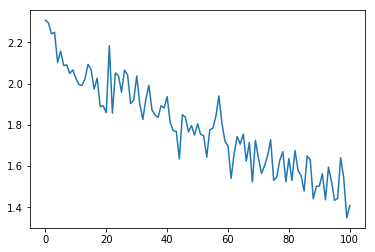

In [54]:
run.recorder.plot_loss()

# Momentum
- Need to save moving average of the gradients

In [18]:
#export
class StatefulOptimizer(Optimizer):
    def __init__(self, params, steppers, stats=None, **defaults):
        self.stats = listify(stats)
        maybe_update(self.stats, defaults, get_defaults)
        # only difference with Optimizer is that it keeps track of stats 
        super().__init__(params, steppers, **defaults)
        self.state = {} # can be many different kinds of states
        
    def step(self):
        for p, hyper in self.grad_params(): # for each param with a gradient
            if p not in self.state: # if it's not being recorded
                self.state[p] = {} # initialize the dictionary
                # update default values only if not exist already
                maybe_update(self.stats, self.state[p], lambda o: o.init_state(p))
            state = self.state[p] # default states of the parameter 
            for stat in self.stats: # multiple stats can be recorded
                state = stat.update(p, state, **hyper) # handle each stat using their own class
            compose(p,self.steppers,**state, **hyper) # does self.steppers(p, **state, **hyper)
            self.state[p] = state # save current state


In [19]:
#export
class Stat(): # base Stat class
    _defaults = {}
    def init_state(self, p):
        raise NotImplementedError
    def update(self, p, state, **kwargs):
        raise NotImplementedError

In [20]:
# one example of Stat --> a new version available below
class AverageGrad(Stat):
    _defaults = dict(mom=0.9)
    def init_state(self,p):
        return {'grad_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, state, mom, **kwargs):
        state['grad_avg'].mul_(mom).add_(p.grad.data) # grad_avg = mom*grad_avg + p.grad
        return state

In [21]:
#export
# A momentum stepper that can use the grad_avg state
def momentum_step(p, lr, grad_avg, **kwargs):
    p.data.add_(-lr, grad_avg) # p -= lr*grad_avg
    return p

In [22]:
sgd_mom_opt = partial(StatefulOptimizer, steppers = [momentum_step,weight_decay],
                     stats=AverageGrad(), wd=0.01)


In [38]:
learn,run = get_learn_run(nfs, data, 0.3, conv_layer, cbs=cbfs, opt_func=sgd_mom_opt)

In [39]:
run.fit(1,learn)

train: [1.883537310231503, tensor(0.3506)]
valid: [1.73543798828125, tensor(0.3920)]


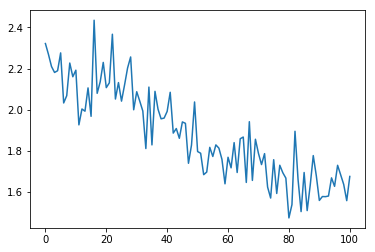

In [40]:
run.recorder.plot_loss()

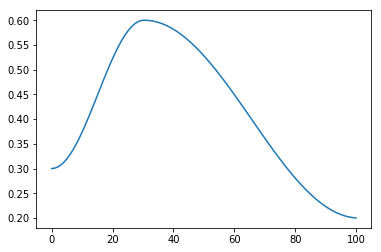

In [41]:
run.recorder.plot_lr()

# Debiasing
Debiasing is here to correct the wrong information we may have in the very first batch. The debias term corresponds to the sum of the coefficient in our moving average. At the time step i, our average is:

$\begin{align*}
avg_{i} &= \beta\ avg_{i-1} + (1-\beta)\ v_{i} = \beta\ (\beta\ avg_{i-2} + (1-\beta)\ v_{i-1}) + (1-\beta)\ v_{i} \\
&= \beta^{2}\ avg_{i-2} + (1-\beta)\ \beta\ v_{i-1} + (1-\beta)\ v_{i} \\
&= \beta^{3}\ avg_{i-3} + (1-\beta)\ \beta^{2}\ v_{i-2} + (1-\beta)\ \beta\ v_{i-1} + (1-\beta)\ v_{i} \\
&\vdots \\
&= (1-\beta)\ \beta^{i}\ v_{0} + (1-\beta)\ \beta^{i-1}\ v_{1} + \cdots + (1-\beta)\ \beta^{2}\ v_{i-2} + (1-\beta)\ \beta\  v_{i-1} + (1-\beta)\ v_{i}
\end{align*}$

and so the sum of the coefficients is

$\begin{align*}
S &=(1-\beta)\ \beta^{i} + (1-\beta)\ \beta^{i-1} + \cdots + (1-\beta)\ \beta^{2} + (1-\beta)\ \beta + (1-\beta) \\
&= (\beta^{i} - \beta^{i+1}) + (\beta^{i-1} - \beta^{i}) + \cdots + (\beta^{2} - \beta^{3}) + (\beta - \beta^{2}) + (1-\beta) \\
&= 1 - \beta^{i+1}
\end{align*}$

since all the other terms cancel out each other.

By dividing by this term, we make our moving average a true average (in the sense that all the coefficients we used for the average sum up to 1).

# Adam and friends

In [23]:
#export
# Adam needs momentum dampening so we added it to AvgGrad
class AverageGrad(Stat):
    _defaults = dict(mom=0.9)
    def __init__(self, dampening:bool=False):
        self.dampening = dampening
    def init_state(self, p):
        return {'grad_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, state, mom, **kwargs):
        # mom_damp = 1 - mom # mom_damp = 1 is undamped
        state['mom_damp'] = 1.-mom if self.dampening else 1.
        # grad_avg = mom*grad_avg - mom_damp*p.grad
        state['grad_avg'].mul_(mom).add_(state['mom_damp'], p.grad.data)
        return state

# record moving avg of gradient squared
class AverageSqrGrad(Stat):
    _defaults = dict(sqr_mom=0.99)
    def __init__(self, dampening:bool=True):
        self.dampening = dampening
    def init_state(self,p):
        return {'sqr_avg': torch.zeros_like(p.grad.data)}
    def update(self,p,state,sqr_mom,**kwargs):
        state['sqr_damp'] = 1 - sqr_mom if self.dampening else 1.
        # sqr_avg = sqr_mom*sqr_avg + sqr_damp*p.grad^2
        state['sqr_avg'].mul_(sqr_mom).addcmul_(state['sqr_damp'], p.grad.data, p.grad.data)
        return state

# count number of steps done during training for debiasing
class StepCount(Stat):
    def init_state(self, p):
        return {'step':0}
    def update(self,p,state,**kwargs):
        state['step'] +=1
        return state
    

This helper function computes the debias term. If we dampening, `damp = 1 - mom` and we get the same result as before. If we don't use dampening, (`damp = 1`) we will need to divide by `1 - mom` because that term is missing everywhere.

In [24]:
#export
# ???
def debias(mom,damp,step):
    return damp * (1 - mom**step) / (1-mom)

# Adam step --> !!! look at the original formula!
def adam_step(p, lr, mom, mom_damp, step, sqr_mom, sqr_damp, grad_avg, sqr_avg, eps, **kwargs):
    debias1 = debias(mom, mom_damp, step)
    debias2 = debias(sqr_mom, sqr_damp, step)
    # p -= lr/(debias1) * grad_avg/(sqrt(sqr_avg/debias2) + eps)
    p.data.addcdiv_(-lr/debias1, grad_avg, (sqr_avg/debias2).sqrt() + eps)
    return p
adam_step._defaults=dict(eps=1e-5)

def adam_opt(xtra_step=None, **kwargs):
    return partial(StatefulOptimizer, steppers=[adam_step, weight_decay]+listify(xtra_step),
                  stats=[AverageGrad(dampening=True), AverageSqrGrad(),StepCount()], **kwargs)

In [27]:
# note different learning rates should be used for different optimizers
cbfs = [partial(AvgStatsCallback,accuracy), Recorder]
learn,run = get_learn_run(nfs, data, 0.001, conv_layer, cbs=cbfs, opt_func=adam_opt())

In [28]:
run.fit(1,learn) # amazing!

train: [1.732716191881883, tensor(0.4058)]
valid: [1.370609130859375, tensor(0.5360)]


# LAMB
LAMB from a [very recent paper](https://arxiv.org/pdf/1904.00962.pdf):

$\begin{align}
g_{t}^{l} &= \nabla L(w_{t-1}^{l}, x_{t}) \\
m_{t}^{l} &= \beta_{1} m_{t-1}^{l} + (1-\beta_{1}) g_{t}^{l} \\
v_{t}^{l} &= \beta_{2} v_{t-1}^{l} + (1-\beta_{2}) g_{t}^{l} \odot g_{t}^{l} \\
m_{t}^{l} &= m_{t}^{l} / (1 - \beta_{1}^{t}) \\
v_{t}^{l} &= v_{t}^{l} / (1 - \beta_{2}^{t}) \\
r_{1} &= \|w_{t-1}^{l}\|_{2} \\
s_{t}^{l} &= \frac{m_{t}^{l}}{\sqrt{v_{t}^{l}} + \epsilon} + \lambda w_{t-1}^{l} \\ 
r_{2} &= \| s_{t}^{l} \|_{2} \\
\eta^{l} &= \eta * r_{1}/r_{2} \\ 
w_{t}^{l} &= w_{t}^{l-1} - \eta_{l} * s_{t}^{l} \\
\end{align}$

In [29]:
def lamb_step(p, lr, mom, mom_damp, step, sqr_mom, sqr_damp, grad_avg, sqr_avg, eps, wd, **kwargs):
    debias1 = debias(mom, mom_damp, step)
    debias2 = debias(sqr_mom, sqr_damp, step)
    r1 = p.data.pow(2).mean().sqrt()
    step = (grad_avg/debias1)/((sqr_avg/debias2).sqrt()+eps) + wd*p.data # weight decay built in here
    r2 = step.pow(2).mean().sqrt()
    # where does this min come from?
    p.data.add_(-lr*min(r1/r2, 10), step)
    return p
lamb_step._defaults = dict(eps=1e-6, wd=0.)

def lamb_opt(xtra_step=None, **kwargs):
    return partial(StatefulOptimizer, steppers=[lamb_step]+listify(xtra_step),
                  stats=[AverageGrad(dampening=True), AverageSqrGrad(),StepCount()], **kwargs)

In [30]:
learn,run = get_learn_run(nfs, data, 0.003, conv_layer, cbs=cbfs, opt_func=lamb_opt())

In [31]:
run.fit(1,learn)

train: [1.9037247520649139, tensor(0.3322)]
valid: [1.585472900390625, tensor(0.4500)]


# Export

In [ ]:
!python notebook2script.py Optimizer_Lesson5_2.ipynb